In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit
from tqdm import tqdm
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

In [2]:
seed = 0

In [3]:
X, Y = data.load_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.Sex.values
A_test = X_test.Sex.values
X_train.insert(0, 'sensitive', A_train) # add sensitive attribute as first column
X_test.insert(0, 'sensitive', A_test)

In [4]:
param_space = {
    "min_child_weight" : FloatDistribution(0.01, 10, log = True),
    "n_estimators" : IntDistribution(5, 50, step=3),
    "eta" : FloatDistribution(0.01, 0.5),
    "max_leaves" : IntDistribution(2, 50), 
    "colsample_bytree" : FloatDistribution(0.1, 1),
    "max_depth" : IntDistribution(3, 10),
    "l2_weight" : FloatDistribution(0.01, 100),
}

## Model without fairness

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [5]:
model_search = OptunaSearchCV(
    models.XtremeFair(fair_weight=0),
    param_space,
    n_trials=100,
    random_state = seed,
    cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold
    verbose = 0,
)
model_search.fit(X_train, Y_train);

/tmp/ipykernel_5400/2182069732.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search = OptunaSearchCV(
[I 2023-11-29 13:49:05,198] A new study created in memory with name: no-name-516cfcf4-8655-41ef-8ded-63e00ec34242
/home/giovani/anaconda3/envs/dual_fair_boost/lib/python3.8/site-packages/optuna/integration/sklearn.py:355: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/home/giovani/anaconda3/envs/dual_fair_boost/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2023-11-29 13:49:05,249] Trial 0 failed with parameters: {'min_child_weight': 0.2871719181692574, 'n_estimators': 35, 'eta': 0.4929322648241834, 'max_leaves': 11, 'colsample_bytree': 0.6250705061352616, 'max_depth': 10, 'l2_weight': 18.056224936021376} because of the 

/home/giovani/anaconda3/envs/dual_fair_boost/lib/python3.8/site-packages/optuna/integration/sklearn.py:355: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
/home/giovani/anaconda3/envs/dual_fair_boost/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2023-11-29 13:49:05,418] Trial 5 failed with parameters: {'min_child_weight': 8.08140988365623, 'n_estimators': 23, 'eta': 0.1278839330107754, 'max_leaves': 21, 'colsample_bytree': 0.22636350833150828, 'max_depth': 10, 'l2_weight': 95.54882872944557} because of the following error: The value nan is not acceptable.
[W 2023-11-29 13:49:05,418] Trial 5 failed with value nan.
/home/giovani/anaconda3/envs/dual_fair_boost/lib/python3.8/site-packages/optuna/integration/sklearn.py:355: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.na

In [ ]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
    p = 0.5,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.891073,0.955446,0.044554,0.395300,0.5,0.838078,0.840959,train_g0
1,0.887910,0.954545,0.045455,0.439592,0.5,0.827731,0.812155,train_g1
2,0.736204,0.873684,0.126316,0.504251,0.5,0.750000,0.805825,test_g0
3,0.747234,0.914894,0.085106,0.556356,0.5,0.722222,0.728814,test_g1


In [ ]:
best_params = model_search.best_params_
best_params

{'min_child_weight': 2.8179641228705448,
 'n_estimators': 29,
 'eta': 0.46278950297763904,
 'max_leaves': 22,
 'colsample_bytree': 0.430460948558557,
 'max_depth': 6,
 'l2_weight': 37.01649253568421}

## Model with dual step

In [32]:
lambda_values = np.append([0],np.logspace(-2, 2, 20))

### Experiment 1

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize ROC. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [33]:
model_search_fair = OptunaSearchCV(
    models.XtremeFair(fair_weight=1),
    param_space,
    n_trials=100,
    random_state = seed,
    cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_5557/2743451004.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-29 13:52:42,035] A new study created in memory with name: no-name-d9286771-688c-418a-8864-88c9cb2c4712


[I 2023-11-29 13:52:42,294] Trial 0 finished with value: 0.7375 and parameters: {'min_child_weight': 0.2871719181692574, 'n_estimators': 35, 'eta': 0.4929322648241834, 'max_leaves': 11, 'colsample_bytree': 0.6250705061352616, 'max_depth': 10, 'l2_weight': 18.056224936021376}. Best is trial 0 with value: 0.7375.
[I 2023-11-29 13:52:42,424] Trial 1 finished with value: 0.7375 and parameters: {'min_child_weight': 1.271762178744101, 'n_estimators': 44, 'eta': 0.4003875546741267, 'max_leaves': 44, 'colsample_bytree': 0.5657519456923042, 'max_depth': 3, 'l2_weight': 29.66572559129418}. Best is trial 0 with value: 0.7375.
[I 2023-11-29 13:52:42,476] Trial 2 finished with value: 0.725 and parameters: {'min_child_weight': 0.026680766551796777, 'n_estimators': 8, 'eta': 0.4348911610307821, 'max_leaves': 34, 'colsample_bytree': 0.42152928551669056, 'max_depth': 10, 'l2_weight': 16.519839536171137}. Best is trial 0 with value: 0.7375.
[I 2023-11-29 13:52:42,598] Trial 3 finished with value: 0.6875

In [34]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'min_child_weight': 0.24462198096868062,
 'n_estimators': 50,
 'eta': 0.4129930600564306,
 'max_leaves': 28,
 'colsample_bytree': 0.2366276251570723,
 'max_depth': 3,
 'l2_weight': 7.393820442640056}

In [35]:
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XtremeFair(
        fair_weight=lambda_value,
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train)
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
        p = 0.5,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


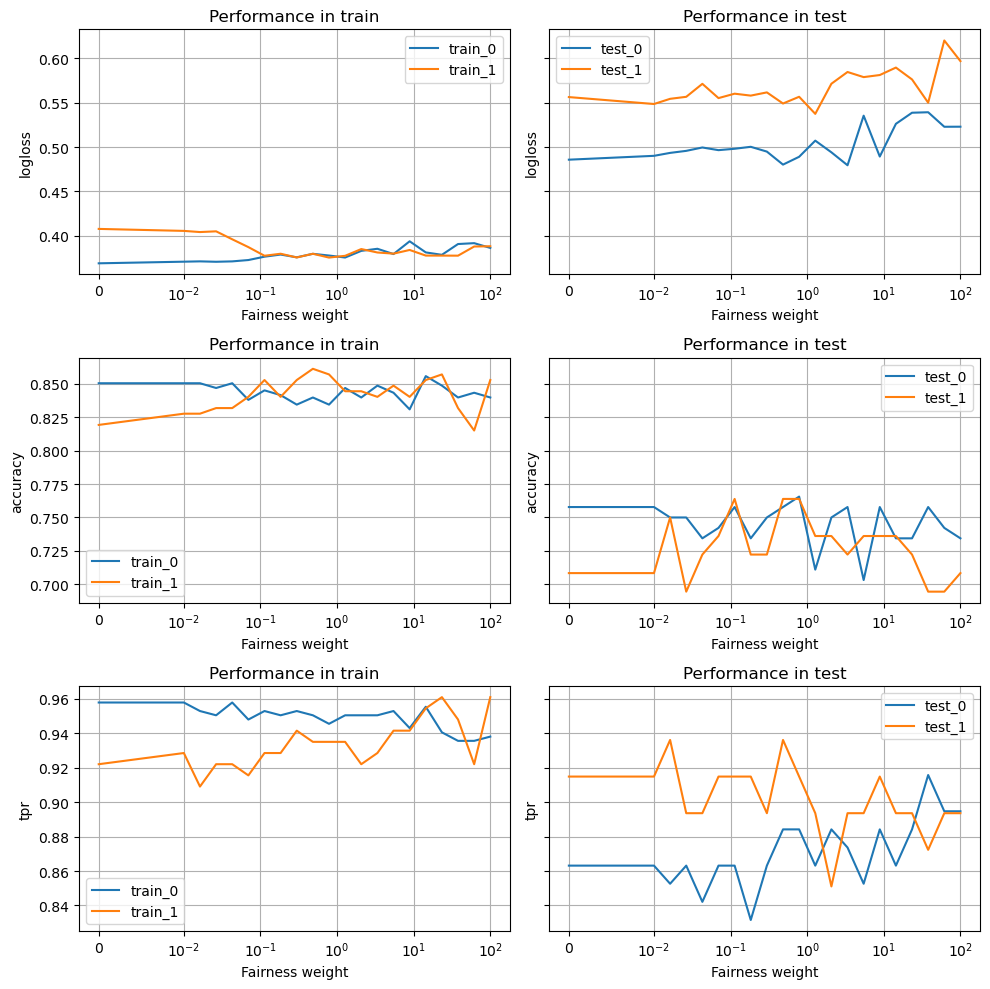

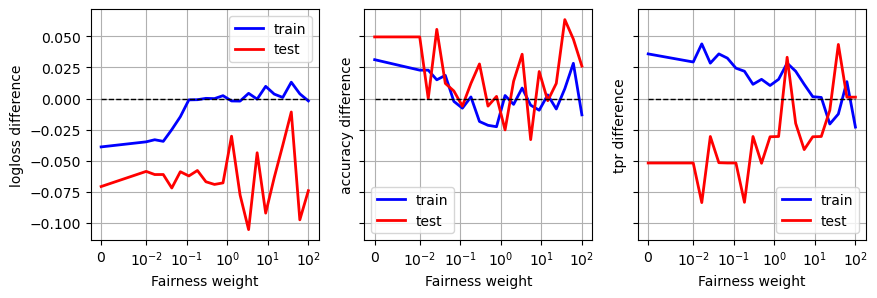

In [36]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 2

- Test different values of fairness weight, and for each, optimize the other parameters to maximize ROC.

In [37]:
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XtremeFair(fair_weight=lambda_value,),
        param_space,
        n_trials=50,
        random_state = seed,
        cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
        p = 0.5,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_5557/1117633236.py:3: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-29 13:53:04,526] A new study created in memory with name: no-name-bb3feb70-f7ad-4043-9899-1b69021f78ba


[I 2023-11-29 13:53:04,658] Trial 0 finished with value: 0.7375 and parameters: {'min_child_weight': 0.2871719181692574, 'n_estimators': 35, 'eta': 0.4929322648241834, 'max_leaves': 11, 'colsample_bytree': 0.6250705061352616, 'max_depth': 10, 'l2_weight': 18.056224936021376}. Best is trial 0 with value: 0.7375.
[I 2023-11-29 13:53:04,760] Trial 1 finished with value: 0.75625 and parameters: {'min_child_weight': 1.271762178744101, 'n_estimators': 44, 'eta': 0.4003875546741267, 'max_leaves': 44, 'colsample_bytree': 0.5657519456923042, 'max_depth': 3, 'l2_weight': 29.66572559129418}. Best is trial 1 with value: 0.75625.
[I 2023-11-29 13:53:04,795] Trial 2 finished with value: 0.73125 and parameters: {'min_child_weight': 0.026680766551796777, 'n_estimators': 8, 'eta': 0.4348911610307821, 'max_leaves': 34, 'colsample_bytree': 0.42152928551669056, 'max_depth': 10, 'l2_weight': 16.519839536171137}. Best is trial 1 with value: 0.75625.
[I 2023-11-29 13:53:04,962] Trial 3 finished with value: 0

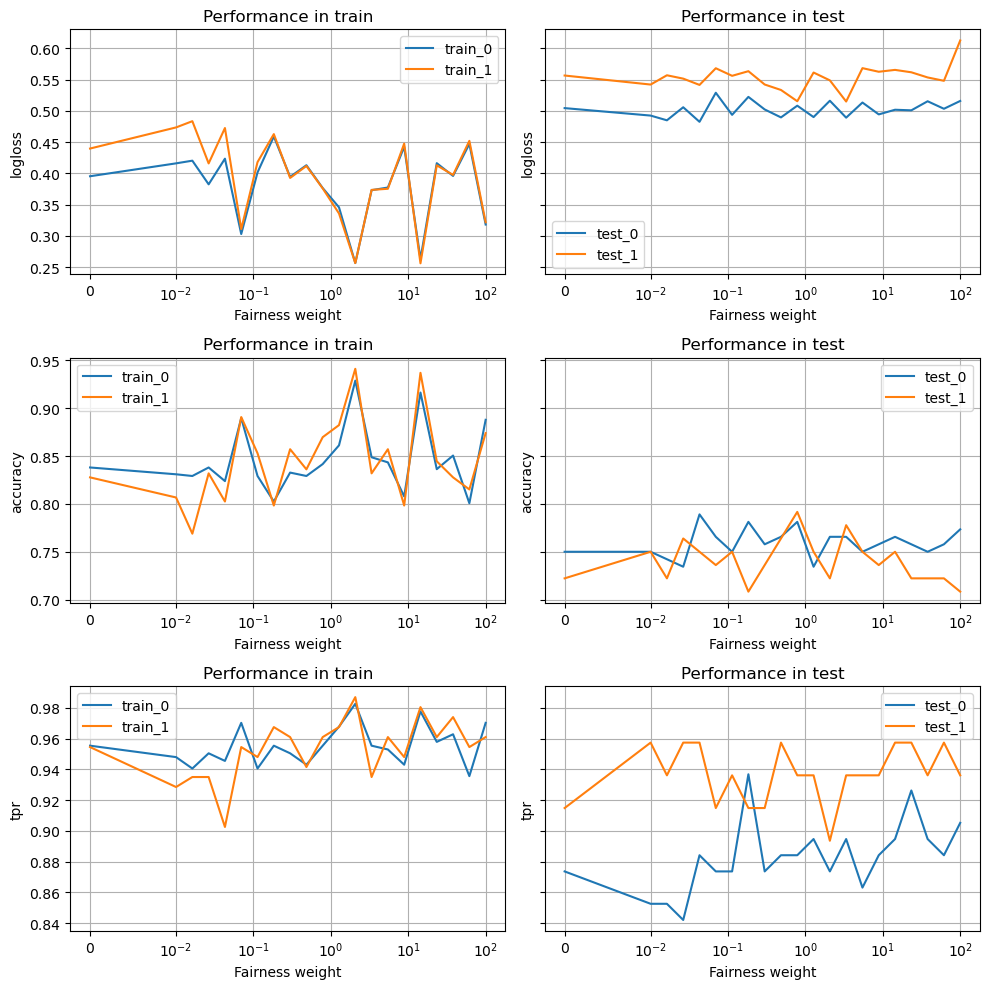

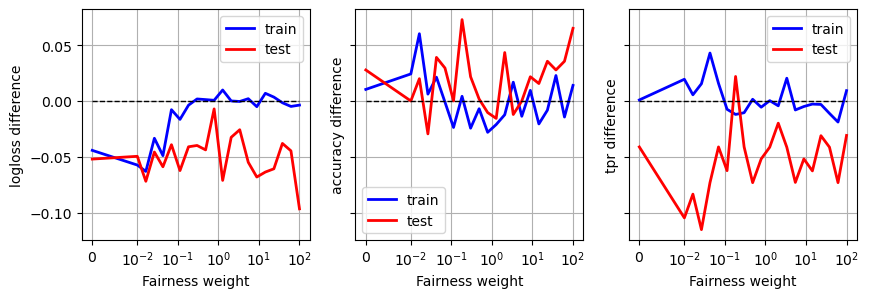

In [38]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 3

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize an weighted sum of ROC and EOD. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [39]:
model_search_fair = OptunaSearchCV(
    models.XtremeFair(alpha = 0.5, fair_weight = 1,),
    param_space,
    n_trials=100,
    random_state = seed,
    cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_5557/3380673914.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-29 13:55:50,611] A new study created in memory with name: no-name-f4a201e2-3d8a-48d9-94b7-f3b5420203b4


[I 2023-11-29 13:55:50,821] Trial 0 finished with value: 0.8462232708930969 and parameters: {'min_child_weight': 0.2871719181692574, 'n_estimators': 35, 'eta': 0.4929322648241834, 'max_leaves': 11, 'colsample_bytree': 0.6250705061352616, 'max_depth': 10, 'l2_weight': 18.056224936021376}. Best is trial 0 with value: 0.8462232708930969.
[I 2023-11-29 13:55:50,907] Trial 1 finished with value: 0.8490236043930054 and parameters: {'min_child_weight': 1.271762178744101, 'n_estimators': 44, 'eta': 0.4003875546741267, 'max_leaves': 44, 'colsample_bytree': 0.5657519456923042, 'max_depth': 3, 'l2_weight': 29.66572559129418}. Best is trial 1 with value: 0.8490236043930054.
[I 2023-11-29 13:55:50,957] Trial 2 finished with value: 0.8529044568538666 and parameters: {'min_child_weight': 0.026680766551796777, 'n_estimators': 8, 'eta': 0.4348911610307821, 'max_leaves': 34, 'colsample_bytree': 0.42152928551669056, 'max_depth': 10, 'l2_weight': 16.519839536171137}. Best is trial 2 with value: 0.85290445

In [40]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'min_child_weight': 0.3405935301793654,
 'n_estimators': 38,
 'eta': 0.46664256405288457,
 'max_leaves': 39,
 'colsample_bytree': 0.496088855421986,
 'max_depth': 4,
 'l2_weight': 28.888820613364995}

In [41]:
utils.eval_model_train_test(
    model_search_fair,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
    p = 0.5,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.907022,0.955446,0.044554,0.369207,0.5,0.855872,0.859688,train_g0
1,0.934292,0.961039,0.038961,0.366238,0.5,0.878151,0.865497,train_g1
2,0.754386,0.894737,0.105263,0.484949,0.5,0.773438,0.817308,test_g0
3,0.740426,0.936170,0.063830,0.558780,0.5,0.750000,0.745763,test_g1


In [42]:
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XtremeFair(
        alpha=0.5,
        fair_weight = lambda_value,
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
        p = 0.5,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


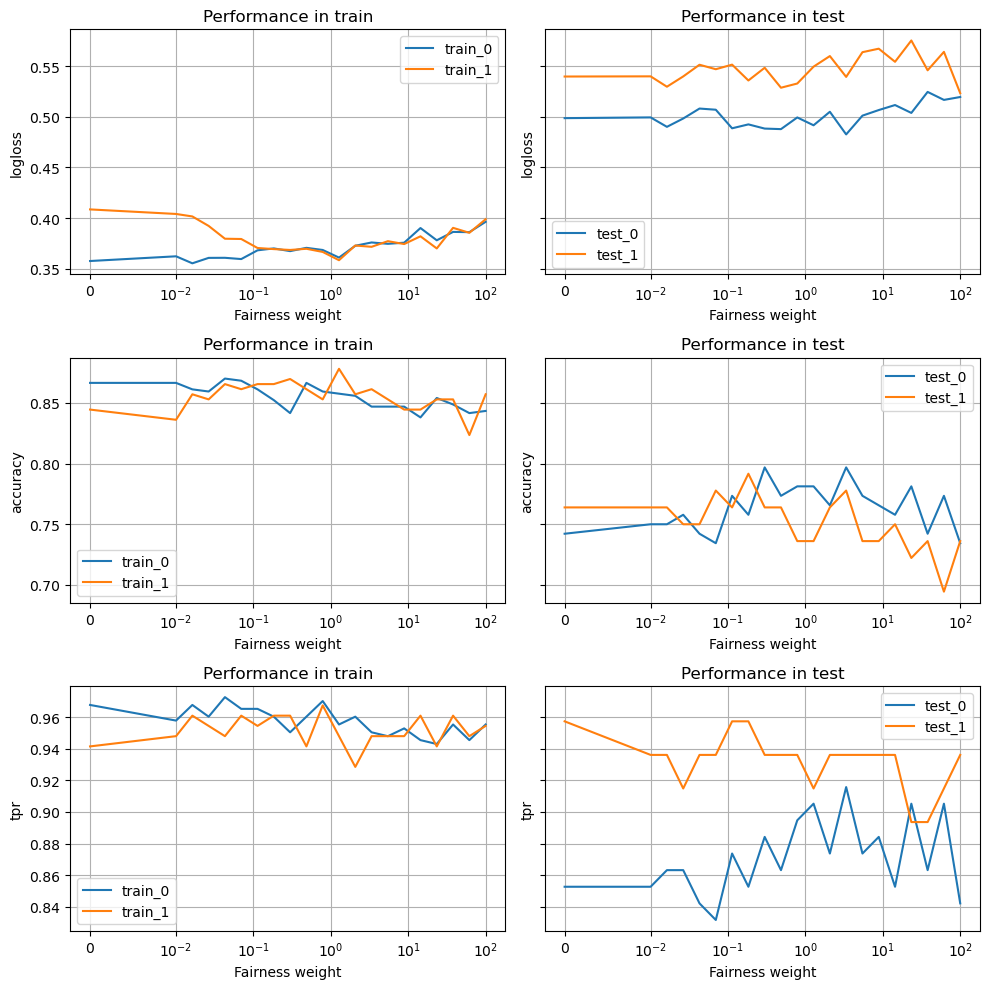

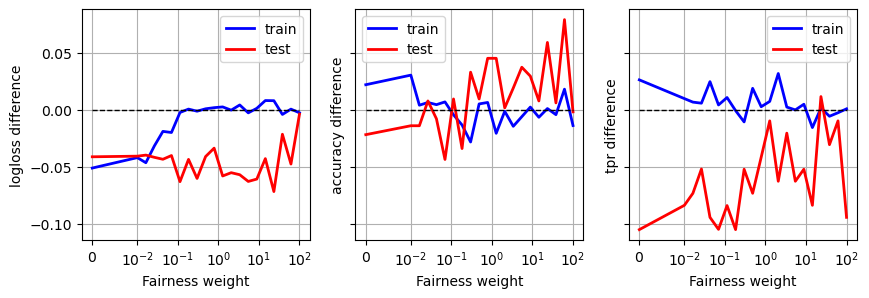

In [43]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 4

In [44]:
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XtremeFair(alpha = 0.5, fair_weight = lambda_value,),
        param_space,
        n_trials=50,
        random_state = seed,
        cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed), # remove this line to run 5-fold
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
        p = 0.5,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_5557/1719541579.py:3: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-29 13:56:09,714] A new study created in memory with name: no-name-7457573e-44dc-4210-b28f-d084efb5dd3d


[I 2023-11-29 13:56:09,837] Trial 0 finished with value: 0.8437212347984314 and parameters: {'min_child_weight': 0.2871719181692574, 'n_estimators': 35, 'eta': 0.4929322648241834, 'max_leaves': 11, 'colsample_bytree': 0.6250705061352616, 'max_depth': 10, 'l2_weight': 18.056224936021376}. Best is trial 0 with value: 0.8437212347984314.
[I 2023-11-29 13:56:09,911] Trial 1 finished with value: 0.8623780190944672 and parameters: {'min_child_weight': 1.271762178744101, 'n_estimators': 44, 'eta': 0.4003875546741267, 'max_leaves': 44, 'colsample_bytree': 0.5657519456923042, 'max_depth': 3, 'l2_weight': 29.66572559129418}. Best is trial 1 with value: 0.8623780190944672.
[I 2023-11-29 13:56:09,941] Trial 2 finished with value: 0.8502142488956451 and parameters: {'min_child_weight': 0.026680766551796777, 'n_estimators': 8, 'eta': 0.4348911610307821, 'max_leaves': 34, 'colsample_bytree': 0.42152928551669056, 'max_depth': 10, 'l2_weight': 16.519839536171137}. Best is trial 1 with value: 0.86237801

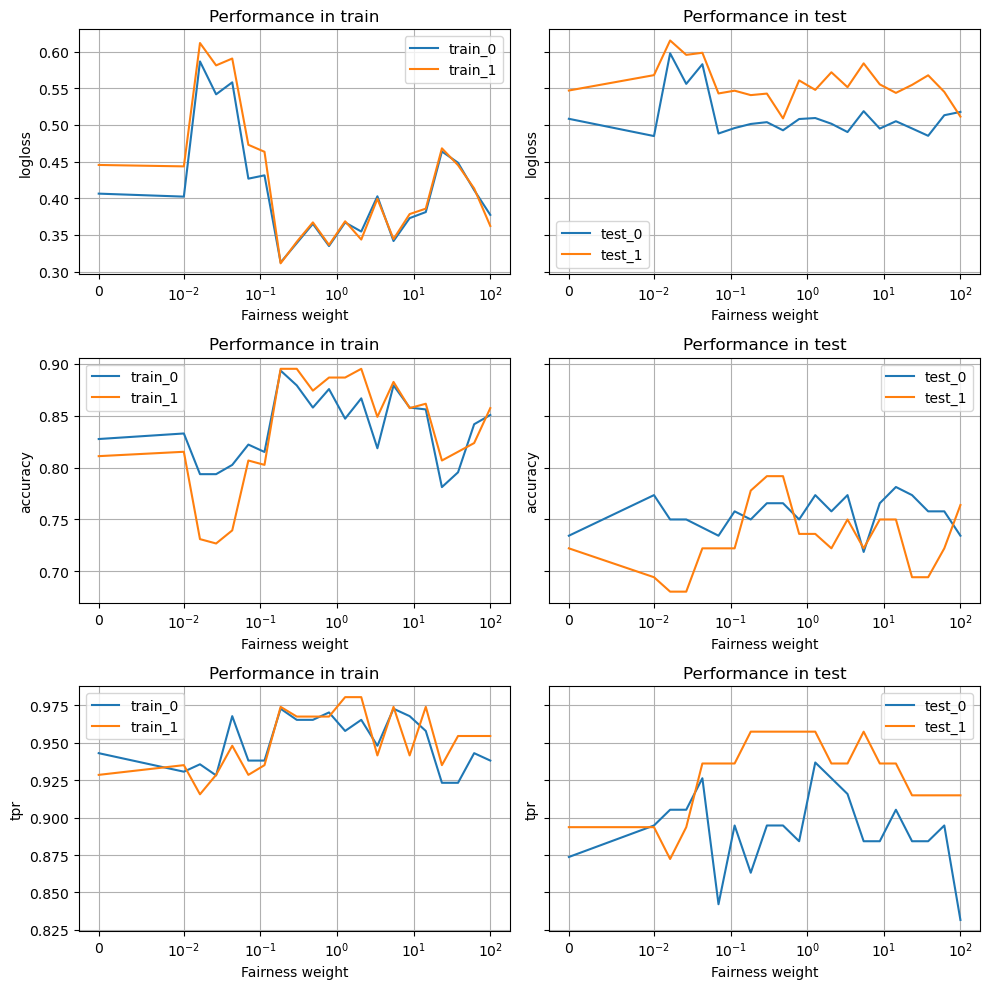

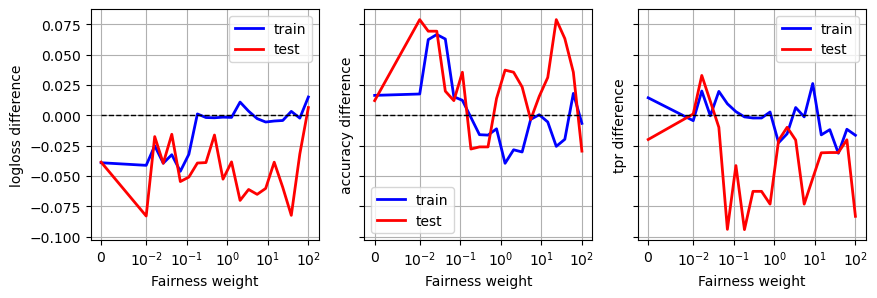

In [45]:
utils.comparison_subgrous_metrics_lambda(results)